In [1]:
# Import required library modules
import yfinance as yf
import pandas as pd
import numpy as np

##  a)

In [2]:
data = yf.download('TSLA', start = '2020-01-01', end = '2021-05-31')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,81.000000,84.258003,80.416000,83.666000,83.666000,51428500
2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500
...,...,...,...,...,...,...
2021-05-24,581.599976,614.479980,573.650024,606.440002,606.440002,34558100
2021-05-25,607.309998,613.989990,595.710022,604.690002,604.690002,28005900
2021-05-26,607.559998,626.169983,601.500000,619.130005,619.130005,28639300


In [4]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<AxesSubplot:title={'center':'Aktienpreis_TSLA'}, xlabel='Date'>

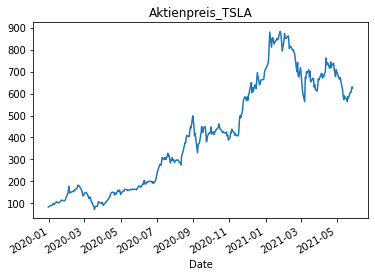

In [33]:
y = data['Close']
y.index = data.index

y.plot(title = 'Aktienpreis_TSLA')

##  b)

In [6]:
# Convert Pandas series to numpy ndarray for further processing
y = y.values

In [7]:
# Split data into trainning and testing using 80/20 ratio.
training_size = int(y.size * 0.8)
print(training_size)

284


In [8]:
# Data normalization using training data's mean and standard deviation.
# y is a ndarray now and its dimension is 1.
training_mean = y[:training_size].mean()
training_std = y[:training_size].std()
# standarize the data
y = (y-training_mean)/training_std

In [9]:
# Define a function to prepare data.
# The time series data are reorganized to form feature vectors and target values.
# For example, let sHistory be 10. A datapoint as a target will have 10 immediately 
# previous 10 values in the time series for its feature vector. 
def data_preprocess(dataset, iStart, iEnd, sHistory):
    data = []
    target = []
    # begin with sHistory to have historical data
    iStart += sHistory
    if iEnd is None:
        iEnd = len(dataset)
    for i in range(iStart, iEnd):
        indices = range(i-sHistory, i)
        data.append(np.reshape(dataset[indices], (sHistory, 1)))
        target.append(dataset[i])
    return np.array(data), np.array(target)

In [10]:
# Let's define number of history data for training and split data into training nd testing datasets.
past_history = 10
xtrain, ytrain = data_preprocess(y, 0, training_size, past_history)
xtest, ytest = data_preprocess(y, training_size, None, past_history)

## c) LSTM

In [11]:
# It's time to get Tensorflow library in and create an LSTM model.
import tensorflow as tf
# Setting seed to ensure reproducibility.
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]),
  tf.keras.layers.Dense(1)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Before taining, you need to configure the model for training.
model.compile(optimizer='Adam',
              loss='mse')

In [14]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [15]:
# For your model to be able to predict something, your need to train your model using training data.
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 4ms/step - loss: 0.1959 - val_loss: 0.1091
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0235 - val_loss: 0.0926
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0634
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0115 - val_loss: 0.0571
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0521
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0530
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0448
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0400
Epoch 9/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0399
Epoch 10/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0376

In [16]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,val_loss
0,0.195937,0.109054
1,0.023548,0.092555
2,0.014911,0.063442
3,0.011525,0.057103
4,0.010344,0.052069


<AxesSubplot:>

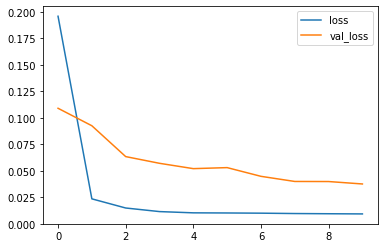

In [17]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [18]:
# For train
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value_train = []
y_orig = []
count =0;
for x, y in p_train.take(20):
    y_orig.append(y[0].numpy())
    t_pred= model.predict(x)
    predicted_value_train.append(t_pred[0])

<AxesSubplot:>

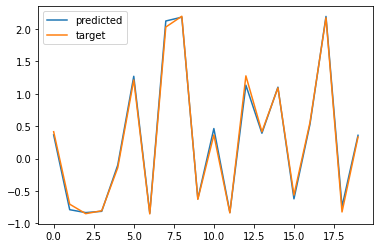

In [19]:
# Plot the predicted value and the target values together.
y_pred_train = [predicted_value_train[i][0] for i in range(len(predicted_value_train))]
result = pd.DataFrame({'predicted':y_pred_train, 'target':y_orig})
result.plot()

In [20]:
# Get the root mean squared error(RMSE)
rmse_train = np.sqrt(np.mean(predicted_value_train - ytrain) ** 2)
rmse_train

0.2557027936077881

In [21]:
# For Test
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value_test = []
y_orig = []
count =0;
for x, y in p_test.take(20):
    y_orig.append(y[0].numpy())
    t_pred= model.predict(x)
    predicted_value_test.append(t_pred[0])

<AxesSubplot:>

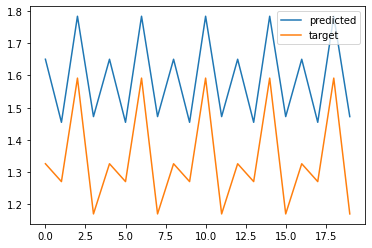

In [22]:
# Plot the predicted value and the target values together.
y_pred_test = [predicted_value_test[i][0] for i in range(len(predicted_value_test))]
result = pd.DataFrame({'predicted':y_pred_test, 'target':y_orig})
result.plot()

In [23]:
# Get the root mean squared error(RMSE)
rmse_test = np.sqrt(np.mean(predicted_value_test - ytest) ** 2)
rmse_test

0.2334152051289607

##  d)

In [24]:
# For your model to be able to predict something, your need to train your model using training data.
history_d = model.fit(p_train, epochs = 200, steps_per_epoch=20, validation_data=p_test, validation_steps=50)

Epoch 1/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0367
Epoch 2/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0334
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0393
Epoch 4/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0310
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0330
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0339
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0313
Epoch 8/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0349
Epoch 9/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0328
Epoch 10/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0369
Epoch 11/

20/20 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0272
Epoch 84/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0297
Epoch 85/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0186
Epoch 86/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0307
Epoch 87/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0227
Epoch 88/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0241
Epoch 89/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0267
Epoch 90/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0246
Epoch 91/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0264
Epoch 92/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0248
Epoch 93/200


In [25]:
# Convert training history to datafram for viewing and graphing.
hist_d = pd.DataFrame(history_d.history)
hist_d.head()

,loss,val_loss
0,0.008698,0.036660
1,0.009222,0.033434
2,0.009278,0.039348
3,0.008880,0.030964
4,0.010026,0.033035


<AxesSubplot:>

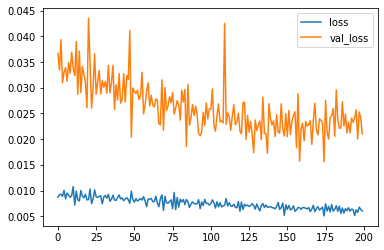

In [26]:
hist_d.plot()

In [27]:
# For train
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value_train_d = []
y_orig = []
count =0;
for x, y in p_train.take(20):
    y_orig.append(y[0].numpy())
    t_pred= model.predict(x)
    predicted_value_train_d.append(t_pred[0])

<AxesSubplot:>

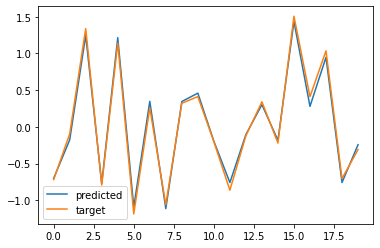

In [28]:
# Plot the predicted value and the target values together.
y_pred_train_d = [predicted_value_train_d[i][0] for i in range(len(predicted_value_train_d))]
result = pd.DataFrame({'predicted':y_pred_train_d, 'target':y_orig})
result.plot()

In [29]:
# Get the root mean squared error(RMSE)
rmse_train_d = np.sqrt(np.mean(predicted_value_train_d - ytrain) ** 2)
rmse_train_d

0.01647603063814166

In [30]:
# For Test
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value_test_d = []
y_orig = []
count =0;
for x, y in p_test.take(20):
    y_orig.append(y[0].numpy())
    t_pred= model.predict(x)
    predicted_value_test_d.append(t_pred[0])

In [31]:
# Get the root mean squared error(RMSE)
rmse_test_d = np.sqrt(np.mean(predicted_value_test_d - ytest) ** 2)
rmse_test_d

0.16493221009569653

## e)